In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import re
import contractions

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

import gensim

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\faruk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [3]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [4]:
DATASETS_PATH = "datasets/"
FILE_NAMES = ["train.txt", "test.txt", "val.txt"]

In [5]:
data = pd.DataFrame()
for file_name in FILE_NAMES:
    temp_data = pd.read_csv(DATASETS_PATH+file_name, sep=";")
    data = pd.concat([data, temp_data]).reset_index(drop=True)

In [6]:
data

,mail,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
19995,im having ssa examination tomorrow in the morn...,sadness
19996,i constantly worry about their fight against n...,joy
19997,i feel its important to share this info for th...,joy
19998,i truly feel that if you are passionate enough...,joy


In [7]:
X = data['mail'].apply(preprocess)
y = pd.get_dummies(data['emotion'])

In [8]:
documents = [_text.split() for _text in X]

In [9]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=200,
                                            window=7,
                                            min_count=10,
                                            workers=8)

In [10]:
w2v_model.build_vocab(documents)

In [11]:
vocab_size = len(w2v_model.wv)

In [12]:
w2v_model.train(documents, total_examples=len(documents), epochs=32)

(4072062, 5973024)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=True)

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 16493


In [15]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=200)

In [16]:
y_test.shape, X_test.shape

((1000, 6), (1000, 200))

# Training

In [17]:
embedding_matrix = np.zeros((vocab_size, 200))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(16493, 200)


In [18]:
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=200, trainable=False)

In [19]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          3298600   
                                                                 
 dropout (Dropout)           (None, 200, 200)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 3,419,606
Trainable params: 121,006
Non-trainable params: 3,298,600
_________________________________________________________________


In [20]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5)]

In [21]:
model.compile(
    optimizer="adam", 
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        "accuracy",
    ],
)

In [22]:
history = model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=1000,
    verbose=1,
    validation_split=0.05,
    callbacks=callbacks
)

Epoch 1/1000
18/18 [==============================] - 98s 5s/step - loss: 1.5859 - accuracy: 0.3789 - val_loss: 1.4611 - val_accuracy: 0.4674 - lr: 0.0010
Epoch 2/1000
18/18 [==============================] - 114s 6s/step - loss: 1.3964 - accuracy: 0.4807 - val_loss: 1.3393 - val_accuracy: 0.5032 - lr: 0.0010
Epoch 3/1000
18/18 [==============================] - 120s 7s/step - loss: 1.3024 - accuracy: 0.5101 - val_loss: 1.2513 - val_accuracy: 0.5232 - lr: 0.0010
Epoch 4/1000
18/18 [==============================] - 132s 7s/step - loss: 1.2441 - accuracy: 0.5309 - val_loss: 1.1733 - val_accuracy: 0.5579 - lr: 0.0010
Epoch 5/1000
18/18 [==============================] - 136s 8s/step - loss: 1.1879 - accuracy: 0.5540 - val_loss: 1.1087 - val_accuracy: 0.5768 - lr: 0.0010
Epoch 6/1000
18/18 [==============================] - 156s 9s/step - loss: 1.1359 - accuracy: 0.5711 - val_loss: 1.0501 - val_accuracy: 0.5989 - lr: 0.0010
Epoch 7/1000
18/18 [==============================] - 159s 9s/ste

18/18 [==============================] - 238s 13s/step - loss: 0.3232 - accuracy: 0.8802 - val_loss: 0.2027 - val_accuracy: 0.9137 - lr: 0.0010
Epoch 54/1000
18/18 [==============================] - 240s 13s/step - loss: 0.3196 - accuracy: 0.8820 - val_loss: 0.2023 - val_accuracy: 0.9158 - lr: 0.0010
Epoch 55/1000
18/18 [==============================] - 233s 13s/step - loss: 0.3078 - accuracy: 0.8872 - val_loss: 0.2042 - val_accuracy: 0.9137 - lr: 0.0010
Epoch 56/1000
18/18 [==============================] - 235s 13s/step - loss: 0.3200 - accuracy: 0.8816 - val_loss: 0.1980 - val_accuracy: 0.9147 - lr: 0.0010
Epoch 57/1000
18/18 [==============================] - 241s 13s/step - loss: 0.3120 - accuracy: 0.8857 - val_loss: 0.2003 - val_accuracy: 0.9179 - lr: 0.0010
Epoch 58/1000
18/18 [==============================] - 242s 13s/step - loss: 0.3118 - accuracy: 0.8857 - val_loss: 0.1949 - val_accuracy: 0.9137 - lr: 0.0010
Epoch 59/1000
18/18 [==============================] - 243s 14s/st

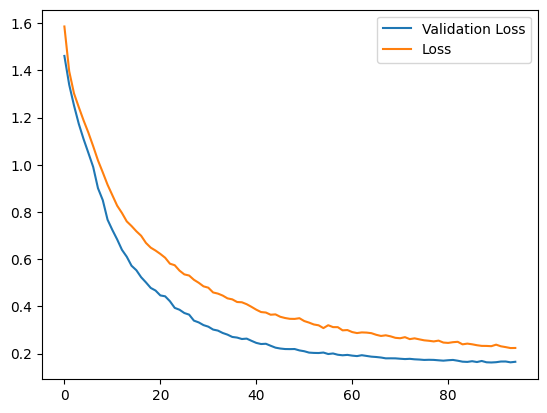

In [38]:
a = plt.plot(history.history['val_loss'], label="Validation Loss")
b = plt.plot(history.history['loss'], label="Loss")
plt.legend()

# Results

In [23]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 3s 94ms/step - loss: 0.1533 - accuracy: 0.9330


[0.15326252579689026, 0.9330000281333923]

In [24]:
result = model.evaluate(X_test, y_test, verbose=0)

print("Test loss: "+ str(result[0]))
print("Test Accuracy: " + str(result[1]))

Test loss: 0.15326252579689026
Test Accuracy: 0.9330000281333923


In [25]:
y_train.sum()/len(y_train)

anger       0.134842
fear        0.119211
joy         0.338263
love        0.081947
sadness     0.289789
surprise    0.035947
dtype: float64

In [26]:
model.save("models/model(0_93).h5")

In [27]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)